# Analysis of Quality of Life trajectories with TrajPy

In this notebook we demonstrate how TrajPy can be used for analysing observational longitudinal data. We use synthetic data that was generated based on the summary statistics from [Head & Neck 5000 study](https://headandneck5000.org.uk/) provided in the [data manual](http://www.headandneck5000.org.uk/content/578904423e79b1.31771192.pdf). We assumed that quality of life (QoL) is associated with age, sex and treatment modality. QoL also presents correlation with the time of measurement, QoL is more seriously impaired at 4 months assuming that the measured is taken close to end of treatment,  with recovery at 12 months.

We will use TrajPy to quantify QoL trajectory and use this new features to train a prediction model for QoL at 36 months.


The dataset is composed by the following variables:

|Variable | description |
|--- | ---|
| hn1_dv_age_cons | age at diagnosis |
| hn1_na8_cb_sex | biological sex |
| hn2_surgery | binary variable indicating if the subject undergone surgery |
| hn2_radiotherapy | binary variable indicating if the subject received radiotherapy treatment|
| hn2_chemotherapy | binary variable indicating if the surbject received chemotherapy treatment|
| hn1_dv_c30_ghs | QoL at diagnosis |
| hn2_dv_c30_ghs | QoL at 4 months|
|hn3_dv_c30_ghs | QoL at 12 months|
| hn4_dv_c30_ghs | QoL at 36 months |

The measurement time for each variable is identified by the prefixes *(hn1, hn2, hn3, hn4)* corresponding to diagnosis, 4 months, 12 months, and 35 months from diagnosis respectively. Instead of using the three QoL measurements as predictors we can use TrajPy's descriptors to summarise the trajectory.



In [3]:
!pip install trajpy --quiet
!pip install --upgrade git+https://github.com/phydev/phy_utils.git@main --quiet
!pip install patchworklib --quiet

  Preparing metadata (setup.py) ... done


In [4]:
import pandas as pd
import numpy as np
from trajpy import trajpy as tj
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import phy_utils.phy_utils as phy
import patchworklib as pw

In [ ]:
df = pd.read_csv('http://raw.githubusercontent.com/ocbe-uio/trajpy/master/data/samples/simulated_qol.csv')

In [6]:
df.head()

,hn1_dv_age_cons,hn1_na8_cb_sex,hn2_surgery,hn2_radiotherapy,hn2_chemotherapy,hn1_dv_c30_ghs,hn2_dv_c30_ghs,hn3_dv_c30_ghs,hn4_dv_c30_ghs
0,57,1 - Male,1 - No,1 - No,2 - Yes,100,94,98,94
1,60,2 - Female,1 - No,2 - Yes,1 - No,100,77,90,93
2,60,2 - Female,2 - Yes,1 - No,2 - Yes,100,69,91,91
3,53,2 - Female,2 - Yes,2 - Yes,2 - Yes,100,47,77,86
4,33,1 - Male,2 - Yes,1 - No,1 - No,100,97,91,96


In [6]:
covariates = ["hn1_dv_age_cons",
              "hn1_na8_cb_sex",
              "hn2_surgery",
              "hn2_radiotherapy",
              "hn2_chemotherapy",
              "hn1_dv_c30_ghs",
              "hn2_dv_c30_ghs",
              "hn3_dv_c30_ghs",
              "hn4_dv_c30_ghs"]

In [7]:
# select covariates
df = df[covariates]
number_of_records = len(df)
time_variables = ["hn1_dv_c30_ghs", "hn2_dv_c30_ghs", "hn3_dv_c30_ghs"]#, "hn4_dv_c30_ghs"]
time_points = np.array([0, 4, 12])#, 36]) # time in months

## Descriptive analysis

We will transform the data from wide to long format by repeating the observations and storing the time dependend variables a single column.

In [8]:
df_long = phy.long_format(df,
             ["hn1_dv_c30_ghs", "hn2_dv_c30_ghs", "hn3_dv_c30_ghs", "hn4_dv_c30_ghs"],
            [0, 4, 12, 36])

In [9]:
df_long.head()

,index,hn1_dv_age_cons,hn1_na8_cb_sex,hn2_surgery,hn2_radiotherapy,hn2_chemotherapy,_dv_c30_ghs,time
0,0,57,1 - Male,1 - No,1 - No,2 - Yes,100.0,0.0
1,0,57,1 - Male,1 - No,1 - No,2 - Yes,94.0,4.0
2,0,57,1 - Male,1 - No,1 - No,2 - Yes,98.0,12.0
3,0,57,1 - Male,1 - No,1 - No,2 - Yes,94.0,36.0
4,1,60,2 - Female,1 - No,2 - Yes,1 - No,100.0,0.0


We can visualize the average QoL curve for this population and the confidence interval:

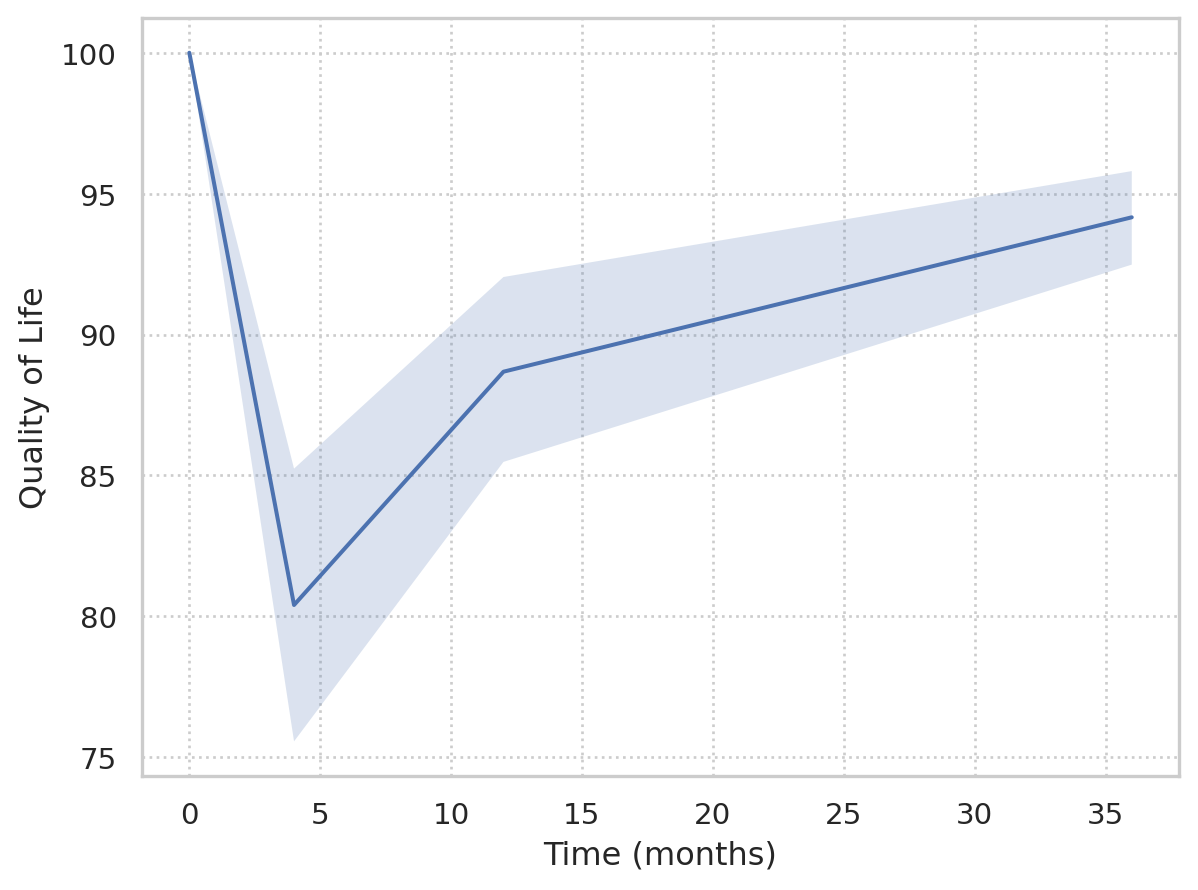

In [10]:
p = so.Plot(df_long.loc[0:100,], y = "_dv_c30_ghs", x = "time")

(
    p.add(so.Line(), so.Agg())
    .add(so.Band(), so.Est())
    .label(x="Time (months)", y = "Quality of Life")
    .theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"})
)

The individual trajectories can also be plotted:

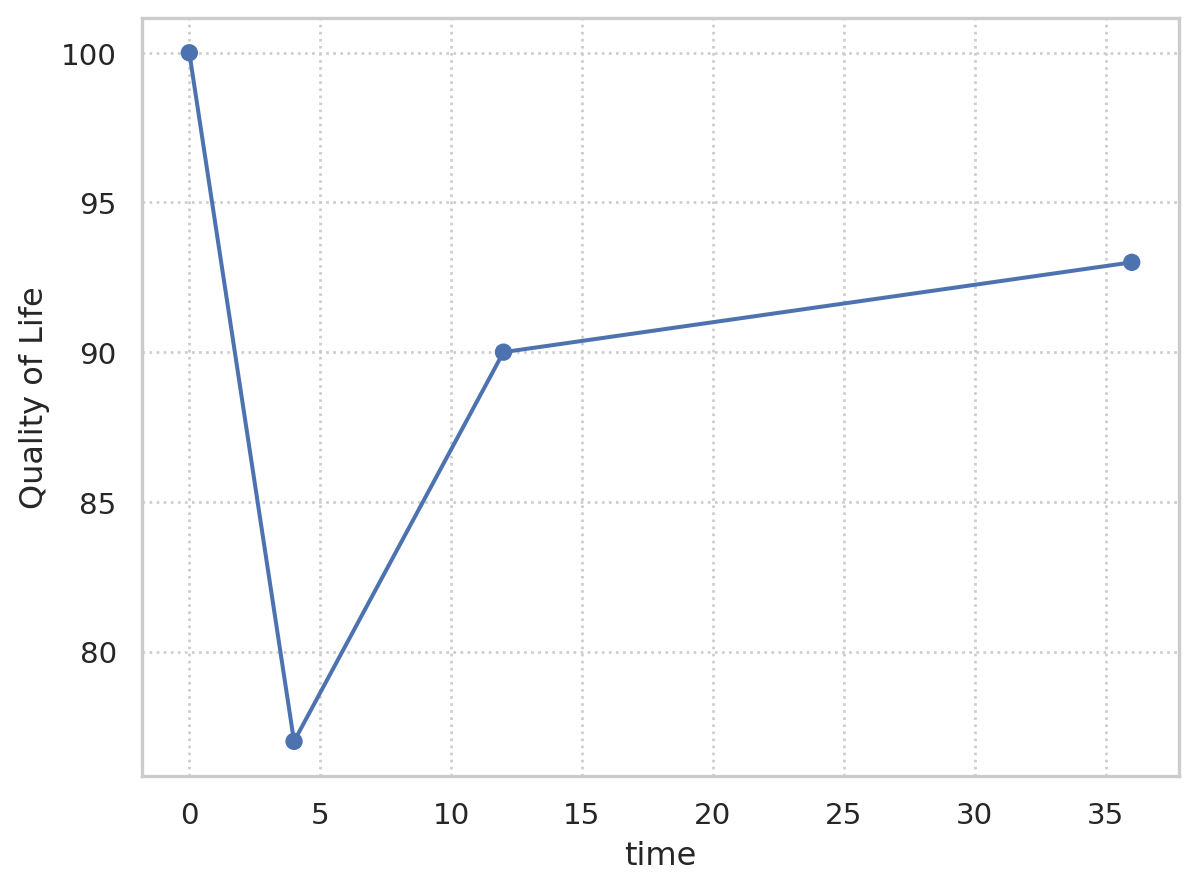

In [18]:
patient_id = 1

p = phy.repeated_measurement_plot(data = df,
                                  y = ["hn1_dv_c30_ghs", "hn2_dv_c30_ghs", "hn3_dv_c30_ghs", "hn4_dv_c30_ghs"],
                                  x = [0, 4, 12, 36],
                                  observation = patient_id)

(
    p.add(so.Dot())
    .add(so.Line())
    .label(x = "time", y = "Quality of Life")
    .theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"})
)


### Compute TrajPy features

Now we will compute features to describe the QoL trajectories for each patient and store them in the data frame `df`.

In [12]:
# initialize trajpy dummy object
Trajectory = tj.Trajectory()

In [13]:
for patient in range(number_of_records):

    Trajectory._r = np.concatenate(
        (time_points.reshape(-1,1), df.iloc[patient][time_variables].to_numpy().reshape(-1,1)),
        axis=1
        )

    Trajectory._t = time_points.reshape(-1,1)
    Trajectory.velocity = Trajectory.velocity_(Trajectory._r[:,1].reshape(-1,1), time_points.reshape(-1,1)).mean()
    Trajectory.gyration_radius = Trajectory.gyration_radius_(Trajectory._r).get('gyration tensor')
    Trajectory.eigenvalues = Trajectory.gyration_radius_(Trajectory._r).get('eigenvalues')
    Trajectory.eigenvectors = Trajectory.gyration_radius_(Trajectory._r).get('eigenvectors')

    df.loc[patient, "efficiency"] = Trajectory.efficiency_(Trajectory._r)
    df.loc[patient, "anisotropy"] = Trajectory.anisotropy_(Trajectory.eigenvalues)
    df.loc[patient, "straightness"] = Trajectory.straightness_(Trajectory._r)
    df.loc[patient, "gaussianity"] = Trajectory.gaussianity_(Trajectory._r)
    df.loc[patient, "efficiency"] = Trajectory.efficiency_(Trajectory._r)
    df.loc[patient, "kurtosis"] = Trajectory.anisotropy_(Trajectory.eigenvalues)


In [8]:
df.head()

,hn1_dv_age_cons,hn1_na8_cb_sex,hn2_surgery,hn2_radiotherapy,hn2_chemotherapy,hn1_dv_c30_ghs,hn2_dv_c30_ghs,hn3_dv_c30_ghs,hn4_dv_c30_ghs,efficiency,anisotropy,straightness,gaussianity,kurtosis
0,57,1 - Male,1 - No,1 - No,2 - Yes,100,94,98,94,0.560606,0.428571,0.753033,-0.774105,0.428571
1,60,2 - Female,1 - No,2 - Yes,1 - No,100,77,90,93,0.156812,0.494334,0.404576,-0.655529,0.494334
2,60,2 - Female,2 - Yes,1 - No,2 - Yes,100,69,91,91,0.073770,0.456732,0.274392,-0.666863,0.456732
3,53,2 - Female,2 - Yes,2 - Yes,2 - Yes,100,47,77,86,0.088810,0.660100,0.308106,-0.595778,0.660100
4,33,1 - Male,2 - Yes,1 - No,1 - No,100,97,91,96,0.900000,1.000000,1.000000,-0.755563,1.000000


In the kernel density estimates (KDE) bellow we can see how the distribution of QoL changes with each one of the new features computed. Gaussianity seems a reasonable candidate for developing a linear model $QoL \sim \mathcal{G} $.

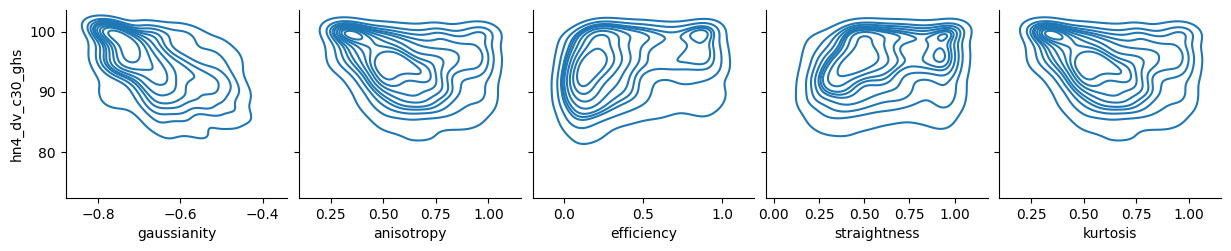

In [63]:
sns.pairplot(df, y_vars = "hn4_dv_c30_ghs", x_vars = ["gaussianity", "anisotropy", "efficiency", "straightness", "kurtosis"], kind="kde")

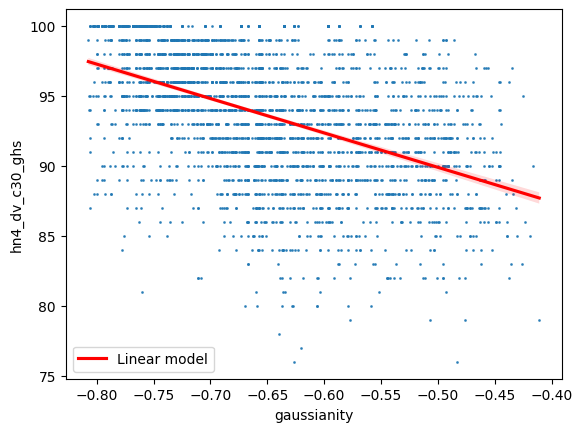

In [57]:
sns.regplot(df,
            y = "hn4_dv_c30_ghs",
            x = "gaussianity",
            scatter_kws={"s": 1, "label": "Observations"},
            line_kws={"color": "red", "label": "Linear model"})
plt.legend()
plt.show()

The boxplots bellow indicate that efficiency is different between treatment strategies. Patients that received radiotherapy and undergone surgery show lower median. This is not surprising since a low efficiency indicates that the QoL presents more changes over time, while high efficiency is measured for stable trajectories. Patients that received radiotherapy or surgery have a higher burden in QoL after treatment which translates in low efficiency.

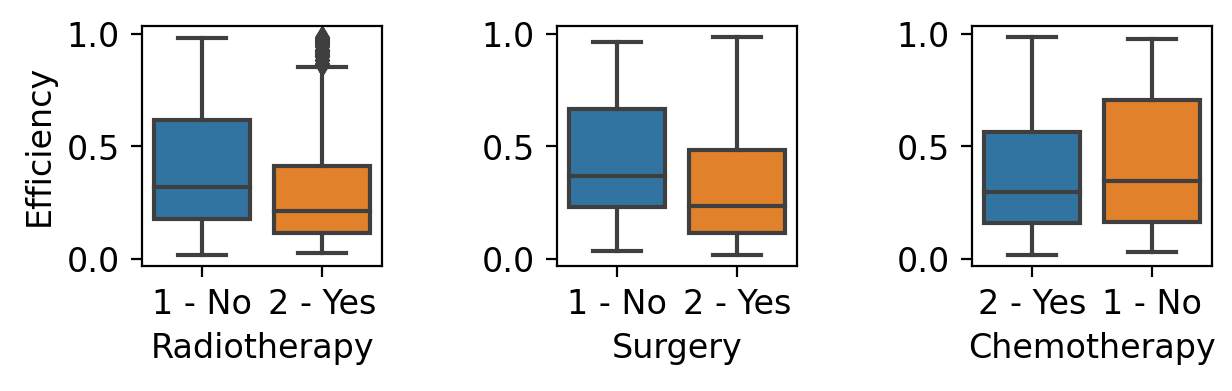

In [27]:
lx, ly = 1.2, 1.2
ax1 = pw.Brick(figsize=(lx,ly))
sns.boxplot(df, x = "hn2_radiotherapy", y = "efficiency", ax=ax1)
ax1.set_xlabel("Radiotherapy")
ax1.set_ylabel("Efficiency")

ax2 = pw.Brick(figsize=(lx,ly))
sns.boxplot(df, x = "hn2_surgery", y = "efficiency", ax=ax2)
ax2.set_xlabel("Surgery")
ax2.set_ylabel("")

ax3 = pw.Brick(figsize=(lx,ly))
sns.boxplot(df, x = "hn2_chemotherapy", y = "efficiency", ax=ax3)
ax3.set_xlabel("Chemotherapy")
ax3.set_ylabel("")

ax1|ax2|ax3

## Encoding two level variables as binary variables

Before modeling this data we will transform all categorical variables with two levels into binary. The default level 0 will identify the category `1 - No` and 1 for `1 - Yes`. For the sex variable `1 - Male` is encoded as default level 0.

In [32]:
df = df.assign(hn1_na8_cb_sex = np.where(df.hn1_na8_cb_sex == "1 - Male", 0, 1) )

# Define the columns to be encoded
columns_to_encode = ["hn2_surgery", "hn2_radiotherapy", "hn2_chemotherapy"]

# Map values using a dictionary
replacement_dict = {"1 - No": 0, "2 - Yes": 1}

# Encode the categorical columns
df[columns_to_encode] = df[columns_to_encode].replace(replacement_dict)

# Bootstraping

We will develop prediction models with the new descriptors and perform internal validation with bootstraping.

In [33]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define the two sets of variables
only_clinical = ["hn1_dv_age_cons", "hn1_na8_cb_sex", "hn2_surgery", "hn2_radiotherapy", "hn2_chemotherapy", "hn1_dv_c30_ghs", "hn2_dv_c30_ghs", "hn3_dv_c30_ghs"]
clinical_with_trajpy = ["hn1_dv_age_cons", "hn1_na8_cb_sex", "hn2_surgery", "hn2_radiotherapy", "hn2_chemotherapy", "anisotropy"]

# Set the number of bootstrap iterations
num_bootstrap = 100

# Random forest hyperparameters
n_estimators = 100      # Number of trees in the forest
max_depth = None        # Maximum depth of the tree (default: None)
min_samples_split = 25   # Minimum number of samples required to split an internal node
min_samples_leaf = 5    # Minimum number of samples required to be at a leaf node
max_features = 1   # Number of features to consider when looking for the best split


# Create arrays to store the bootstrapped performance metrics
mse_only_clinical = np.zeros(num_bootstrap)
mse_clinical_with_trajpy = np.zeros(num_bootstrap)

for i in range(num_bootstrap):
    # Generate a bootstrap sample by resampling with replacement
    bootstrap_sample = df.sample(frac=1, replace=True, random_state=i)

    # Split the bootstrap sample into features and target
    X_bootstrap_only_clinical = bootstrap_sample[only_clinical]
    X_bootstrap_clinical_with_trajpy = bootstrap_sample[clinical_with_trajpy]
    y_bootstrap = bootstrap_sample["hn4_dv_c30_ghs"]

    # Split the dataset into training and testing sets
    X_train_only_clinical, X_test_only_clinical, y_train_bootstrap, y_test_bootstrap = train_test_split(X_bootstrap_only_clinical, y_bootstrap, test_size=0.2, random_state=42)
    X_train_clinical_with_trajpy, X_test_clinical_with_trajpy = train_test_split(X_bootstrap_clinical_with_trajpy, test_size=0.2, random_state=42)

    # Initialize the Random Forest Regressor
    model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=max_features,
                                      random_state=42)

    # Fit the model on the bootstrap training data for only clinical variables
    model.fit(X_train_only_clinical, y_train_bootstrap)

    # Make predictions on the bootstrap testing data
    y_pred_only_clinical = model.predict(X_test_only_clinical)

    # Calculate MSE and R-squared for the bootstrap sample
    mse_only_clinical[i] = mean_squared_error(y_test_bootstrap, y_pred_only_clinical)

    # Repeat the same process for clinical_with_trajpy variables
    model.fit(X_train_clinical_with_trajpy, y_train_bootstrap)
    y_pred_clinical_with_trajpy = model.predict(X_test_clinical_with_trajpy)
    mse_clinical_with_trajpy[i] = mean_squared_error(y_test_bootstrap, y_pred_clinical_with_trajpy)



In [35]:
# Calculate the means and confidence intervals of performance metrics
mse_only_clinical_mean = np.mean(mse_only_clinical)
mse_only_clinical_ci = phy.confidence_interval(mse_only_clinical)

mse_clinical_with_trajpy_mean = np.mean(mse_clinical_with_trajpy)
mse_clinical_with_trajpy_ci = phy.confidence_interval(mse_clinical_with_trajpy)


# Print the results
print("Model performance with only clinical variables:")
print(f"Mean MSE: {mse_only_clinical_mean}")
print(f"95% Confidence Interval for MSE: {mse_only_clinical_ci[0]} - {mse_only_clinical_ci[1]}")

print("\nModel performance with clinical variables and trajpy variables:")
print(f"Mean MSE: {mse_clinical_with_trajpy_mean}")
print(f"95% Confidence Interval for MSE: {mse_clinical_with_trajpy_ci[0]} - {mse_clinical_with_trajpy_ci[1]}")


Model performance with only clinical variables:
Mean MSE: 7.194307508443098
95% Confidence Interval for MSE: 7.105681249340444 - 7.282933767545751

Model performance with clinical variables and trajpy variables:
Mean MSE: 7.068724568521673
95% Confidence Interval for MSE: 6.980578553886994 - 7.156870583156351


## Conclusion

I hope that this toy analysis convinced you about the potential application of TrajPy for clinical longitudinal data. Trajpy allow to summarise trajectories into fewer variables while preserving or increasing the prediction power. This is specially important in small data situations, which is often the majority of the cases in clinical data.